In [1]:
import numpy as np 
import pandas as pd

#For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For text preprocessing
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

#For creating the neural network model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
train = pd.read_csv('/Corona_NLP_test.csv',encoding='latin1')
test = pd.read_csv('/Corona_NLP_test.csv',encoding='latin1')

In [3]:
train.head()


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [4]:
print('Shape of Train datatset:',train.shape)
print('Shape of Test dataset:',test.shape)

Shape of Train datatset: (3798, 6)
Shape of Test dataset: (3798, 6)


In [5]:
#Train dataset
train.isnull().sum()


UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [6]:
#Test dataset
test.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

# Data Visualization of different sentiments classes


In [7]:
#Defining variables to count the appearances of each sentiments in the dataset
print("Train")
dist_train = train['Sentiment'].value_counts()
print(dist_train)
print("Test")
dist_test = test['Sentiment'].value_counts()
print(dist_test)

Train
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64
Test
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64


Text(0, 0.5, 'Count')

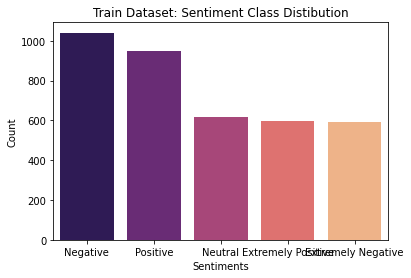

In [8]:
#Create plot
sns.barplot(x= dist_train.index, y= dist_train.values, palette = 'magma')

#Set the size of plot
sns.set(rc = {'figure.figsize':(20,7)})

#Set the title for plot
plt.title('Train Dataset: Sentiment Class Distibution')

#Label the X axis of the plot
plt.xlabel('Sentiments')

#Label the Y axis of the plot
plt.ylabel('Count')

Text(0, 0.5, 'Count')

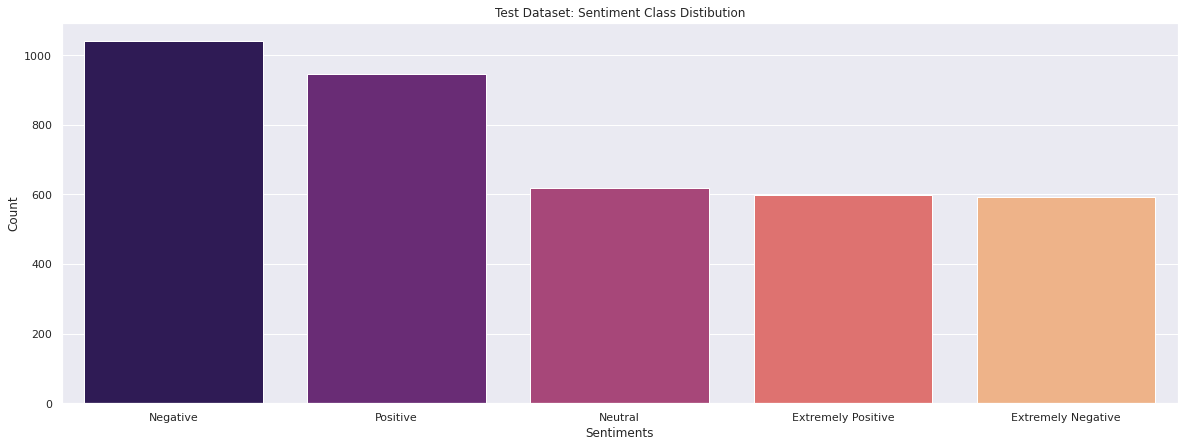

In [9]:
#Create plot
sns.barplot(x= dist_test.index, y= dist_test.values, palette = 'magma')

#Set the size of plot
sns.set(rc = {'figure.figsize':(10,7)})

#Set the title for plot
plt.title('Test Dataset: Sentiment Class Distibution')

#Label the X axis of the plot
plt.xlabel('Sentiments')

#Label the Y axis of the plot
plt.ylabel('Count')


- We don't need any other columns except Tweets and Sentiment. We will predict the sentiments only on the basis of tweets irrespective of their location or any other features.


# Define features and target variables

In [10]:
X = train['OriginalTweet'].copy()
y = train['Sentiment'].copy()

- Text preprocessing: Remove Stopwords and Tokenize


In [11]:
def data_cleaner(tweet):
    
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)
    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    
    return tweet

In [19]:
#Defining a variable for stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
#Apply the above defined function to train dataset
X_cleaned = X.apply(data_cleaner)
X_cleaned.head()

0    TRENDING: New Yorkers encounter empty supermar...
1    When I find hand sanitizer Fred Meyer, I turne...
2                          Find protect loved ones . ?
3    buying hits City anxious shoppers stock food&a...
4    # News # NewsMelb One week everyone buying bab...
Name: OriginalTweet, dtype: object

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)
X = tokenizer.texts_to_sequences(X_cleaned)
vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("\nFor Example:\n")
print("Sentence:\n{}".format(X_cleaned[1]))
print("\nAfter tokenizing :\n{}".format(X[1]))

X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[1]))

Vocabulary size: 9846

For Example:

Sentence:
When I find hand sanitizer Fred Meyer, I turned . But $ . pack Purell??!!Check concerns driving prices.

After tokenizing :
[164, 2, 193, 53, 113, 3363, 3364, 2, 2184, 157, 811, 4766, 189, 480, 1259, 13]

After padding :
[ 164    2  193   53  113 3363 3364    2 2184  157  811 4766  189  480
 1259   13    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


- There are five types of sentiments initially in the dataset. We can club Extremely Negative and Negative tweets together for ease and the same for Extremely Positive and Positive tweets.


In [22]:
encoding = {'Extremely Negative': 0,'Negative': 0,'Neutral': 1,'Positive':2,'Extremely Positive': 2}

labels = ['Negative', 'Neutral', 'Positive']
           
y.replace(encoding, inplace=True)
y

0       0
1       2
2       2
3       0
4       1
       ..
3793    2
3794    0
3795    1
3796    0
3797    2
Name: Sentiment, Length: 3798, dtype: int64

- Define a neural network model

In [23]:
tf.keras.backend.clear_session()

# Initialize hyper parameters
EPOCHS = 2
BATCH_SIZE = 32
embedding_dim = 16
units = 256

#Create a Sequential Model
model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(64, activation="relu"),
    L.Dropout(0.4),
    L.Dense(3)
])

In [24]:
#Compile the model
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])

In [25]:
history = model.fit(X, y, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE)

Epoch 1/2
105/105 [==============================] - 34s 286ms/step - loss: 1.0142 - accuracy: 0.4354 - val_loss: 0.9870 - val_accuracy: 0.4276
Epoch 2/2
105/105 [==============================] - 27s 259ms/step - loss: 0.9099 - accuracy: 0.4949 - val_loss: 0.9132 - val_accuracy: 0.6382


In [26]:
X_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()

#Apply the tweets preprocessing functions to test dataset
X_test = X_test.apply(data_cleaner)

X_test = tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(X_test, padding='post')

y_test.replace(encoding, inplace=True)

In [27]:
pred = model.predict(X_test)
pred

array([[ 0.9165603 , -1.4173925 ,  0.7718682 ],
       [ 0.9133649 , -1.6009263 ,  1.0760461 ],
       [ 0.25004283, -0.5677537 ,  0.38300276],
       ...,
       [-0.17504463,  0.08242936, -0.15889776],
       [ 1.2730256 , -2.0942228 ,  1.2558697 ],
       [ 0.89198387, -1.514754  ,  0.96875143]], dtype=float32)

In [28]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.7801228761672974
Test Accuracy: 0.7185360789299011
